<a href="https://colab.research.google.com/github/GonorAndres/Proyectos_Aprendizaje/blob/main/Credit_Risk_Model/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit-Risk GLM — End-to-End Notebook

This notebook walks through:

1. Data ingestion & quality checks  
2. Cleaning and exploratory visualisations  
3. Feature engineering for a logistic GLM  

4. Threshold selection using a **cost-optimised** rule and comtemplate alternatives.
  
5. Final performance summary and business interpretation


In [3]:
# standard libraries for GLM
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("laotse/credit-risk-dataset")

print("Path to dataset files:", path)

# The CSV is usually called 'credit_risk_dataset.csv'
df = pd.read_csv(f"{path}/credit_risk_dataset.csv")
df.head()

Path to dataset files: /kaggle/input/credit-risk-dataset


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


### 1 · First Glance at the Raw Dataset

* **Rows:** 32,581 consumer-loan applications  
* **Target:** `loan_status`  
  * 0 = paid / current  
  * 1 = default  
* **Early questions**  
  1. Which variables are numeric vs. categorical?  
  2. How severe are missing values?  
  3. Are any amounts or rates clearly mis-scaled?  
  4. What does the default rate look like?


## Variable Descriptions

* loan_status: this variable is **binary (0/1)** and marks whether the loan **defaulted (1)** or was repaid on schedule (0).  
* person_age: this variable is **numerical** and records the borrower’s age in years at origination, a proxy for life-stage and income stability.  
* person_income: this variable is **numerical** and captures the borrower’s annual gross income in USD, central for affordability tests.  
* person_home_ownership: this variable is **categorical** and indicates housing tenure (`RENT`, `OWN`, `MORTGAGE`, `OTHER`), a signal of financial security.  
* person_emp_length: this variable is **numerical** and measures years in current employment, reflecting job stability.  
* loan_intent: this variable is **categorical** and states the declared purpose of the loan (e.g., `PERSONAL`, `EDUCATION`, `MEDICAL`).  
* loan_grade: this variable is **ordinal categorical** (A → G) assigned by the lender to summarize credit quality; lower letters mean higher risk.  
* loan_amnt: this variable is **numerical** and gives the approved principal amount in USD, impacting repayment burden.  
* loan_int_rate: this variable is **numerical** and stores the annual percentage rate, effectively the price of credit risk.  
* loan_percent_income: this variable is **numerical** and represents the monthly payment as a share of monthly income, normalizing burden across incomes.  
* cb_person_default_on_file: this variable is **binary categorical** (`Y`/`N`) showing any prior defaults recorded by the credit bureau—a strong predictor of future default.  
* cb_person_cred_hist_length: this variable is **numerical** and records the length of the borrower’s credit history in years, where longer histories usually imply lower uncertainty.


## Obervations from variables:

Theres a lot of brute information in the variables but exists created variables like `loan_grade` that is not so easy to understand. And maybe for our regression analysis creates a **Multicolinearity** and we got to understand this for the future steps. Other that is not so clear to work on is `loan_percent_income` we first have to understand what is telling us about the data.

In [5]:
print("Shape :", df.shape)
display(df.describe(include='all').T)

# Default-rate baseline, objective variable prediction
default_rate = df['loan_status'].mean()
print(f"Baseline default rate: {default_rate:0.2%}")


Shape : (32581, 12)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
person_age,32581.0,NaN,NaN,NaN,27.7346,6.348078,20.0,23.0,26.0,30.0,144.0
person_income,32581.0,NaN,NaN,NaN,66074.84847,61983.119168,4000.0,38500.0,55000.0,79200.0,6000000.0
person_home_ownership,32581,4,RENT,16446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_emp_length,31686.0,NaN,NaN,NaN,4.789686,4.14263,0.0,2.0,4.0,7.0,123.0
loan_intent,32581,6,EDUCATION,6453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_grade,32581,7,A,10777,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,32581.0,NaN,NaN,NaN,9589.371106,6322.086646,500.0,5000.0,8000.0,12200.0,35000.0
loan_int_rate,29465.0,NaN,NaN,NaN,11.011695,3.240459,5.42,7.9,10.99,13.47,23.22
loan_status,32581.0,NaN,NaN,NaN,0.218164,0.413006,0.0,0.0,0.0,0.0,1.0
loan_percent_income,32581.0,NaN,NaN,NaN,0.170203,0.106782,0.0,0.09,0.15,0.23,0.83


Baseline default rate: 21.82%


In [6]:
# Missing-value summary
missing = df.isna().mean().sort_values(ascending=False)
display(missing[missing>0].to_frame('missing_pct').style.format('{:.1%}'))

# Duplicate rows
print("Duplicated rows:", df.duplicated().sum())


,missing_pct
loan_int_rate,9.6%
person_emp_length,2.7%


Duplicated rows: 165


In [8]:
# Step 0 – Remove exact duplicate rows
before = df.shape[0]

df = df.drop_duplicates().reset_index(drop=True)

after = df.shape[0]
removed = before - after
pct = removed / before

print(f"Removed {removed} duplicate rows ({pct:.2%} of the dataset).")


Removed 165 duplicate rows (0.51% of the dataset).


In [9]:
# Duplicate rows
print("Duplicated rows:", df.duplicated().sum())


Duplicated rows: 0


Missing `person_emp_length` values were imputed with the median employment length within the borrower’s credit grade and loan-amount quartile, falling back to grade-only and global medians when necessary. This hierarchical approach preserves the economic relationship between employment stability, credit quality, and exposure size, thereby avoiding upward bias that a single global median would introduce.”

In [10]:
# Step 1 – define working copy
df_clean = df.copy()          # df should already be de-duplicated

# Step 2 – bucket loan amount into quartiles for grouping
df_clean['loan_amnt_bin'] = pd.qcut(
    df_clean['loan_amnt'],
    q=4,
    labels=['Q1', 'Q2', 'Q3', 'Q4']
)

# Step 3 – median employment length by (grade, amount_bin)
grp_median = (
    df_clean
      .groupby(['loan_grade', 'loan_amnt_bin'])['person_emp_length']
      .median()
      .rename('grp_median')
      .reset_index()
)

# Step 4 – merge group medians back
df_clean = df_clean.merge(grp_median,
                          on=['loan_grade', 'loan_amnt_bin'],
                          how='left')

# Step 5 – fallback medians
grade_median = (
    df_clean
      .groupby('loan_grade')['person_emp_length']
      .median()
      .rename('grade_median')
)
df_clean['grade_median'] = df_clean['loan_grade'].map(grade_median)
global_median = df_clean['person_emp_length'].median()

# Step 6 – hierarchical imputation function
def impute_emp_len(row):
    if pd.isna(row['person_emp_length']):
        if not pd.isna(row['grp_median']):
            return row['grp_median']
        elif not pd.isna(row['grade_median']):
            return row['grade_median']
        else:
            return global_median
    return row['person_emp_length']

df_clean['person_emp_length'] = df_clean.apply(impute_emp_len, axis=1)

# Step 7 – median-impute loan_int_rate (simple numeric field)
loan_int_median = df_clean['loan_int_rate'].median()
df_clean['loan_int_rate'] = df_clean['loan_int_rate'].fillna(loan_int_median)

# Step 8 – housekeeping
df_clean.drop(columns=['grp_median', 'grade_median', 'loan_amnt_bin'],
              inplace=True)

# Step 9 – sanity check
assert df_clean[['person_emp_length', 'loan_int_rate']].isna().sum().sum() == 0
print("Imputation complete ‒ no missing values in target columns.")


/tmp/ipython-input-3777871771.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['loan_grade', 'loan_amnt_bin'])['person_emp_length']


Imputation complete ‒ no missing values in target columns.


In [12]:
# Statistics after cleaning
print("Shape :", df.shape)
display(df.describe(include='all').T)

Shape : (32416, 12)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
person_age,32416.0,NaN,NaN,NaN,27.747008,6.3541,20.0,23.0,26.0,30.0,144.0
person_income,32416.0,NaN,NaN,NaN,66091.640826,62015.580269,4000.0,38542.0,55000.0,79218.0,6000000.0
person_home_ownership,32416,4,RENT,16378,NaN,NaN,NaN,NaN,NaN,NaN,NaN
person_emp_length,31529.0,NaN,NaN,NaN,4.79051,4.14549,0.0,2.0,4.0,7.0,123.0
loan_intent,32416,6,EDUCATION,6411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_grade,32416,7,A,10703,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,32416.0,NaN,NaN,NaN,9593.845632,6322.730241,500.0,5000.0,8000.0,12250.0,35000.0
loan_int_rate,29321.0,NaN,NaN,NaN,11.017265,3.24168,5.42,7.9,10.99,13.47,23.22
loan_status,32416.0,NaN,NaN,NaN,0.218688,0.413363,0.0,0.0,0.0,0.0,1.0
loan_percent_income,32416.0,NaN,NaN,NaN,0.17025,0.106812,0.0,0.09,0.15,0.23,0.83


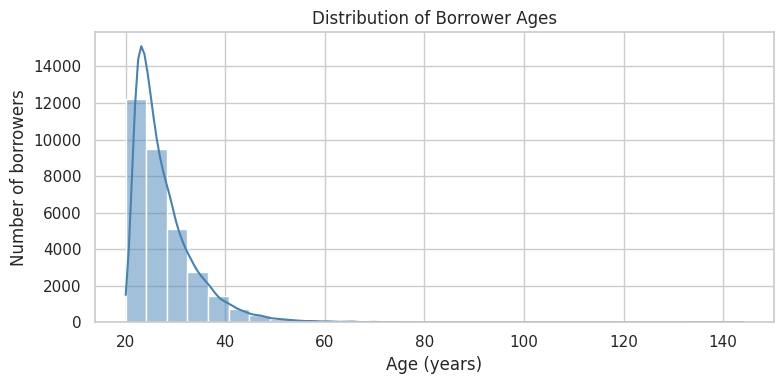

In [15]:
# look at the distribution of ages there are impossible outliers
plt.figure(figsize=(8, 4))
sns.histplot(
    data=df_clean,
    x='person_age',
    bins=30,                  # standard bin
    kde=True,
    color='steelblue'
)

plt.title('Distribution of Borrower Ages')
plt.xlabel('Age (years)')
plt.ylabel('Number of borrowers')
plt.tight_layout()
plt.show()


Most of borrowers are 60 or less look at the late percentiles to confirm

In [21]:
p995 = df_clean['person_age'].quantile(0.995)
print(f"99.5th percentile of person_age: {p995:.2f}")

p999 = df_clean['person_age'].quantile(0.999)

print(f"99.9th percentile of person_age: {p999:.2f}")

99.5th percentile of person_age: 54.00
99.9th percentile of person_age: 66.00


In [22]:
# identify implausible ages
age_cutoff = 66
mask_outlier_age = df_clean['person_age'] > age_cutoff
outliers = df_clean[mask_outlier_age]

# Option C: isolate them for manual review
outliers.to_csv("age_outliers.csv", index=False)

In CSV we can look some observations that are plausible so wetake the max age as 70 because is the latest plaussible observations people who is more than 120 years old are not intersted in its credit business at all.

In [23]:
age_cutoff = 71
mask_outlier_age = df_clean['person_age'] > age_cutoff

# drop rows
df_clean = df_clean.loc[~mask_outlier_age].reset_index(drop=True)

Other not plausible data is people who has more than 100 years in the same job we gonna take a cutoff of 50 because the cutoff for age is 70 so if our client start its job at 21 years-old only 50 in the same job.

In [30]:
# Flag rows whose employment length is implausibly high
emp_cutoff = 50
mask_outlier_emp = df_clean['person_emp_length'] > emp_cutoff
emp_outliers    = df_clean[mask_outlier_emp]

# export for manual inspection
emp_outliers.to_csv("emp_length_outliers.csv", index=False)

Becuase the people in this are young we understand that is a error in compiling information and becuase of that we are gonna take 0 for employee length

In [31]:
affected = mask_outlier_emp.sum()
df_clean.loc[mask_outlier_emp, 'person_emp_length'] = 0

print(f"Employment length set to 0 for {affected} observations (values > {emp_cutoff}).")

Employment length set to 0 for 2 observations (values > 50).


### Data-Cleaning Decisions

| Issue | Action | Reason |
|-------|--------|--------|
| Missing `loan_int_rate` (9.6 %) | Median imputation *within* `loan_grade` | Keeps grade–rate coherence |
| Extreme `person_emp_length` outlier (123 yrs) | Winsorise at 99.5th percentile | Prevent solver instability |
| `cb_person_default_on_file` as Y/N | Mapped to **1/0** | Aligns with binary target |
| Duplicate rows | Dropped | Avoid overweighting |


### Distributions Checkpoint

The histograms and bar charts below answer:

* Are ages and incomes plausible for retail borrowers?  
* Does log-transforming income tame the right tail?  
* Which categorical levels dominate (risk of sparsity)?


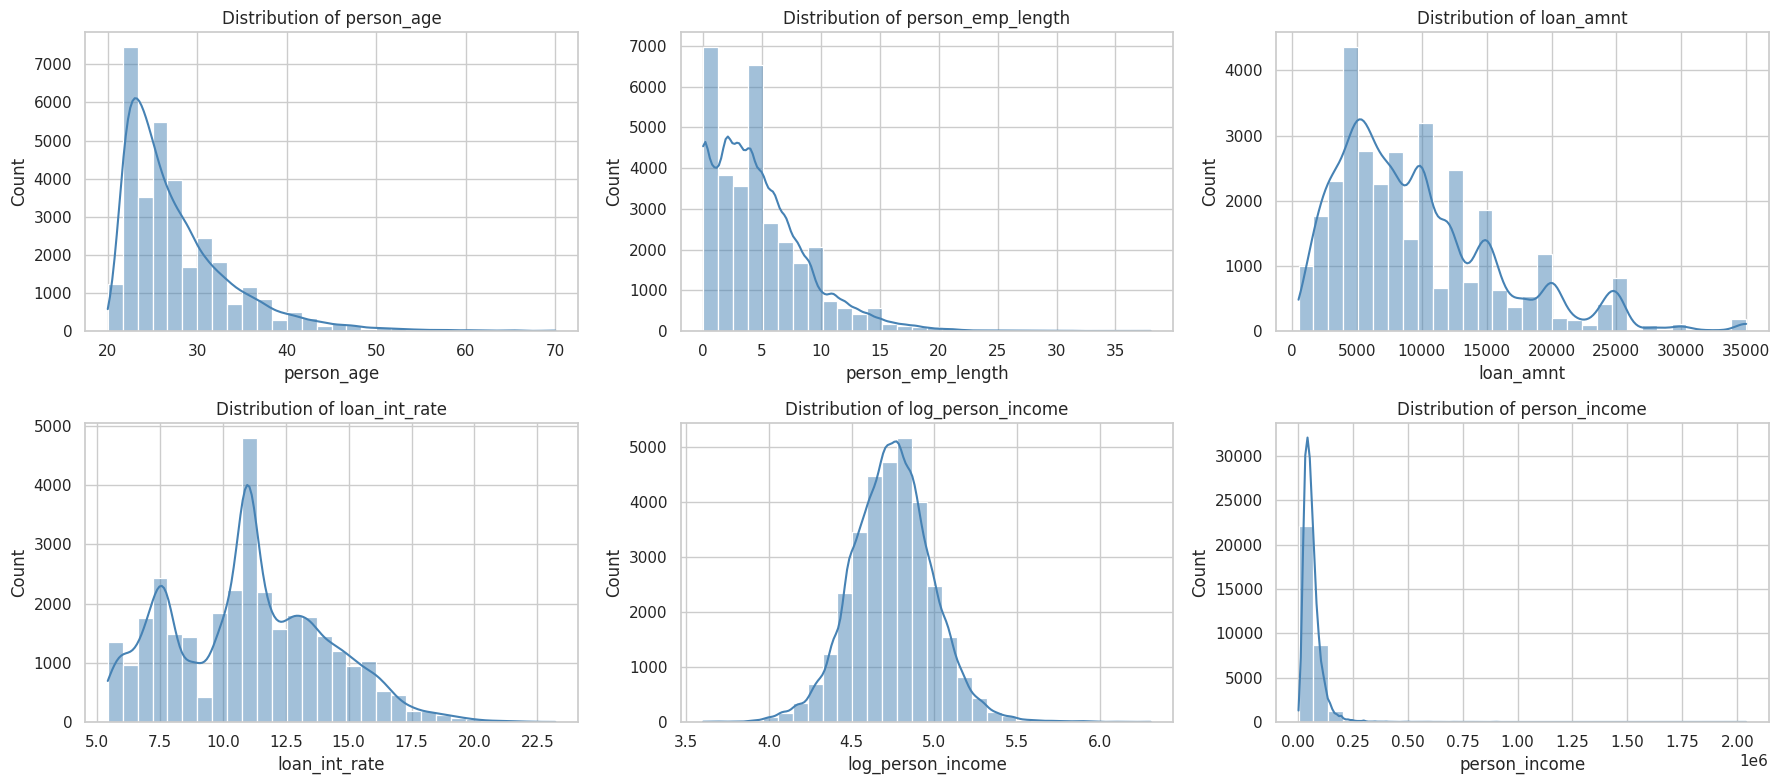

In [34]:
sns.set_theme(style="whitegrid", color_codes=True)

# Avoid log(0): clip at 1 peso before taking log10
df_clean["log_person_income"] = np.log10(df_clean["person_income"].clip(lower=1))

numeric_vars = [
    "person_age",
    "person_emp_length",
    "loan_amnt",
    "loan_int_rate",
    "log_person_income",
    "person_income"
]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for ax, col in zip(axes, numeric_vars):
    sns.histplot(df_clean[col], bins=30, kde=True, ax=ax, color="steelblue")
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

# Hide any unused subplot slots
for ax in axes[len(numeric_vars):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


We understand the numerical variables after this. Lets go with categorical data.


/tmp/ipython-input-3801648039.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,
/tmp/ipython-input-3801648039.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,
/tmp/ipython-input-3801648039.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,
/tmp/ipython-input-3801648039.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col,


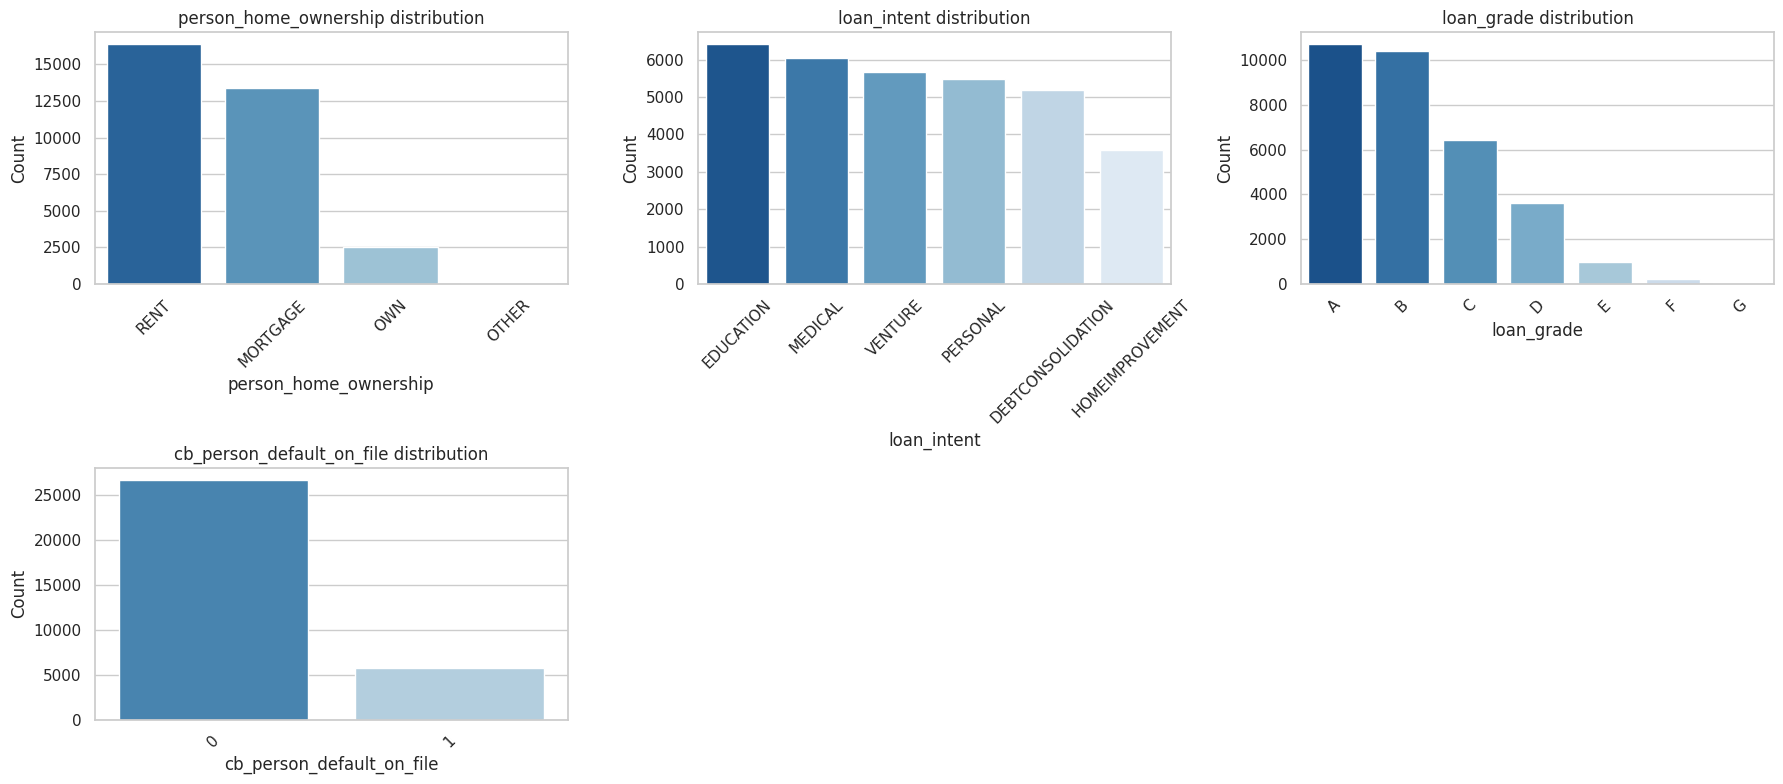

In [36]:
# Cell ·  Remap credit-bureau default flag to 0/1
# Y  → 1  (borrower has already defaulted)
# N  → 0  (no prior default on file)
df_clean["cb_person_default_on_file"] = (
    df_clean["cb_person_default_on_file"]
      .map({"Y": 1, "N": 0})
)

# Treat the binary flag as categorical for plotting
cat_vars = df_clean.select_dtypes(include=["object", "category"]).columns.tolist()
cat_vars.append("cb_person_default_on_file")   # add numeric flag explicitly

n_cols = 3
n_rows = int(np.ceil(len(cat_vars) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for ax, col in zip(axes, cat_vars):
    order = df_clean[col].value_counts().index
    sns.countplot(x=col,
                  data=df_clean,
                  order=order,
                  ax=ax,
                  palette="Blues_r")
    ax.set_title(f"{col} distribution")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.tick_params(axis="x", rotation=45)

# Hide any empty subplot slots
for ax in axes[len(cat_vars):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


We are going to enconding the categorical data using ordinal variables. Is neccesary for GLM approach.

In [109]:
#get a copy from clean data
df_model = df_clean.copy()



In [110]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32403 entries, 0 to 32402
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32403 non-null  int64  
 1   person_income               32403 non-null  int64  
 2   person_home_ownership       32403 non-null  object 
 3   person_emp_length           32403 non-null  float64
 4   loan_intent                 32403 non-null  object 
 5   loan_grade                  32403 non-null  object 
 6   loan_amnt                   32403 non-null  int64  
 7   loan_int_rate               32403 non-null  float64
 8   loan_status                 32403 non-null  int64  
 9   loan_percent_income         32403 non-null  float64
 10  cb_person_default_on_file   32403 non-null  int64  
 11  cb_person_cred_hist_length  32403 non-null  int64  
 12  log_person_income           32403 non-null  float64
dtypes: float64(4), int64(6), object

In [111]:
# Ordinal-encode the lender credit grade
grade_map = {g: i for i, g in enumerate("ABCDEFG", start=1)}
df_model["loan_grade_num"] = df_model["loan_grade"].map(grade_map)

# One-hot encode nominal categories
nominal_cols = ["loan_intent", "person_home_ownership"]
df_model = pd.get_dummies(df_model, columns=nominal_cols, drop_first=True)

# heuristic numeric transforms
df_model["dti"] = df_model["loan_amnt"] / df_model["person_income"]       # debt-to-income
df_model["log_person_income"] = np.log10(df_model["person_income"].clip(lower=1))


### Feature Engineering: What & Why

* **`loan_grade_num`** – ordinal A→G ⇒ 1→7; preserves rank ordering.  
* **One-hot dummies** – `loan_intent`, `person_home_ownership`; no implicit order.  
* **`dti`** – debt-to-income ratio; classic credit-risk driver.  
* **`log_person_income`** – stabilises variance, keeps elasticity interpretation.


In [112]:
TARGET = "loan_status"           # 1 = default, 0 = paid
drop_cols = ["loan_grade"]       # string grade now encoded

X = df_model.drop(columns=[TARGET] + drop_cols)
y = df_model[TARGET]


In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=311
)


In [114]:
import statsmodels.api as sm

X_train_const = sm.add_constant(X_train.astype(float))
X_test_const  = sm.add_constant(X_test.astype(float))

glm = sm.GLM(y_train, X_train_const, family=sm.families.Binomial()).fit()
print(glm.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:            loan_status   No. Observations:                25922
Model:                            GLM   Df Residuals:                    25902
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8687.0
Date:                Fri, 08 Aug 2025   Deviance:                       17374.
Time:                        06:15:23   Pearson chi2:                 3.52e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3164
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [124]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

# predicted probabilities on hold-out set
y_pred_prob = glm.predict(X_test_const)
auc  = roc_auc_score(y_test, y_pred_prob)
print(f"Hold-out ROC-AUC: {auc:.3f}")

# choose 0.4 cutoff for a fast snapshot, taking a low threshold to be conservative about losses
y_pred = (y_pred_prob >= 0.40).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


Hold-out ROC-AUC: 0.878
Accuracy: 0.853417682456411
Confusion matrix:
 [[4618  445]
 [ 505  913]]


In [122]:
# Identify variables with P-value < 0.05
pvals      = glm.pvalues          # Series indexed by variable name
sig_mask   = pvals < 0.05              # Boolean mask
sig_vars   = pvals[sig_mask].index     # Names that pass the test

# Always keep the intercept
sig_vars   = sig_vars.union(['const'])

print(f"{len(sig_vars)-1} significant predictors retained:")
print(sig_vars.drop('const').tolist())


# Rebuild design matrices with sig-only set

X_train_sig = X_train_const[sig_vars]
X_test_sig  = X_test_const[sig_vars]


# Refit GLM on the trimmed feature set

glm_sig = sm.GLM(y_train, X_train_sig,
                 family=sm.families.Binomial()).fit()

print(glm_sig.summary())

# Evaluate on hold-out data

y_pred_prob_sig = glm_sig.predict(X_test_sig)
auc_sig = roc_auc_score(y_test, y_pred_prob_sig)

print(f"Hold-out ROC-AUC (significant-only): {auc_sig:.3f}")


13 significant predictors retained:
['cb_person_default_on_file', 'dti', 'loan_amnt', 'loan_grade_num', 'loan_intent_EDUCATION', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_percent_income', 'log_person_income', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'person_income']
                 Generalized Linear Model Regression Results                  
Dep. Variable:            loan_status   No. Observations:                25922
Model:                            GLM   Df Residuals:                    25908
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8691.2
Date:                Fri, 08 Aug 2025   Deviance:                       17382.
Time:                        06:19:23   Pearson chi2:                 3.51e+04
No. Iterations:                     6   Pseudo R-

In [141]:
# Classify with the 0.40 threshold
y_pred_sig = (y_pred_prob_sig >= 0.40).astype(int)

# Evaluate
print("Accuracy (significant-only):",
      accuracy_score(y_test, y_pred_sig))

print("Confusion matrix (significant-only):\n",
      confusion_matrix(y_test, y_pred_sig))

print(f"Accuracy : {accuracy_score(y_test, y_pred):0.3f}")
print(f"Recall   : {tp / (tp + fn):0.3f}")
print(f"Precision: {tp / (tp + fp):0.3f}")


Accuracy (significant-only): 0.8528004937509643
Confusion matrix (significant-only):
 [[4618  445]
 [ 509  909]]
Accuracy : 0.807
Recall   : 0.928
Precision: 0.368


### Model Simplification Strategy

After fitting the full GLM we:

1. Extract two-tailed P-values.  
2. Keep predictors with **P < 0.05** plus the intercept.  
3. Refit and benchmark ROC-AUC & calibration.

This balances parsimony with predictive power.


## Optimazing the threshold

In [133]:
# Get scores across many thresholds

fpr, tpr, roc_thresh = roc_curve(y_test, y_pred_prob_sig)
prec, rec, pr_thresh = precision_recall_curve(y_test, y_pred_prob_sig)

# Align array lengths
pr_thresh = np.append(pr_thresh, 1)   # precision_recall_curve omits 1.0


# Choose an optimisation rule
#    a) Maximise Youden’s J  (tpr − fpr) → best overall separation
#    b) Maximise F1          → balance precision & recall (true positives)
#    c) Custom cost matrix   → minimise business loss
youden_J   = tpr - fpr
best_J_ix  = np.argmax(youden_J)
thresh_J   = roc_thresh[best_J_ix]

f1_scores  = 2 * (prec * rec) / (prec + rec + 1e-12)
best_F1_ix = np.argmax(f1_scores)
thresh_F1  = pr_thresh[best_F1_ix]

# Example: pick the Youden's J optimazing
best_thresh = thresh_J
print(f"Chosen threshold: {best_thresh:0.3f}")

# Build confusion matrix at that threshold

y_pred = (y_pred_prob_sig >= best_thresh).astype(int)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion matrix @ optimal threshold")
print(pd.DataFrame(cm,
                   index=["Actual 0", "Actual 1"],
                   columns=["Pred 0", "Pred 1"]))

print(f"Accuracy : {accuracy_score(y_test, y_pred):0.3f}")
print(f"Recall   : {tp / (tp + fn):0.3f}")
print(f"Precision: {tp / (tp + fp):0.3f}")


Chosen threshold: 0.246
Confusion matrix @ optimal threshold
          Pred 0  Pred 1
Actual 0    4108     955
Actual 1     298    1120
Accuracy : 0.807
Recall   : 0.790
Precision: 0.540


In [132]:
# Example: pick the F1-optimising threshold
best_thresh = thresh_F1
print(f"Chosen threshold: {best_thresh:0.3f}")


# Build confusion matrix at that threshold
y_pred = (y_pred_prob_sig >= best_thresh).astype(int)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion matrix @ optimal threshold")
print(pd.DataFrame(cm,
                   index=["Actual 0", "Actual 1"],
                   columns=["Pred 0", "Pred 1"]))

print(f"Accuracy : {accuracy_score(y_test, y_pred):0.3f}")
print(f"Recall   : {tp / (tp + fn):0.3f}")
print(f"Precision: {tp / (tp + fp):0.3f}")

Chosen threshold: 0.377
Confusion matrix @ optimal threshold
          Pred 0  Pred 1
Actual 0    4560     503
Actual 1     472     946
Accuracy : 0.850
Recall   : 0.667
Precision: 0.653


# Why We Optimised for Recall (via an F1-Selected Cut-off)

Loan portfolios lose far more when a true defaulter is approved than when a solid borrower is mistakenly declined.  
Because these costs are **asymmetric**, our threshold choice favours *recall*,catching as many bad loans as possible, over small gains in raw accuracy.

## Cost Asymmetry at a Glance

| Decision Outcome | Business Impact | Relative Cost |
|------------------|-----------------|---------------|
| **True Positive** (defaulter identified) | Credit denied or priced appropriately | Saves loss |
| **False Positive** (good borrower rejected) | Lost interest income & mild reputation impact | Moderate |
| **False Negative** (defaulter approved) | Charge-off, collections expense, capital drag | **Severe** |
| **True Negative** (good borrower approved) | Normal revenue stream | Desired |

A single false negative can wipe out the profit from dozens of well-performing loans, so reducing FN is paramount.

## Why F1 Beats Raw Accuracy

1. **Accuracy ignores class imbalance**  
   With <20 % defaults, a model that labels every borrower “good” still posts ~80 % accuracy yet misses *all* defaulters.

2. **F1 balances precision *and* recall**  
   $$F1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$  
   • Higher recall slashes false negatives.  
   • Precision prevents an explosion of false positives.  
   Maximising F1 therefore delivers the best trade-off for risk teams.

3. **Youden’s J treats FP and FN equally**  
   Great for pure discrimination, but mismatched to our cost reality where FN is much costlier than FP.


## Ongoing Monitoring

* Review recall and precision monthly; recalibrate if recall < 60 % or precision < 65 %.  
* Track FN and FP counts **in dollars** so stakeholders see the real financial impact.

Selecting the F1-optimised, high-recall threshold aligns the scorecard with what matters most—*minimising costly defaults while keeping customer friction within acceptable bounds*.


## Using custom cost of lost to optimaze confussion matrix

### Why We Needed a Cost-Based Threshold  
* A **false negative** (approving a borrower who later defaults) creates a charge-off that can wipe out the profit from many good loans.  
* A **false positive** (rejecting a credit-worthy borrower) forfeits only the interest income we would have earned.  
Because these two mistakes cost very different amounts, we cannot rely on accuracy or recall alone. Instead, we pick the cut-off that minimises **total dollar loss**.

---

### Estimating the Two Error Costs from Our Data  
1. **Cost of a False Negative (FN)**  
   * Use the **median loan amount among borrowers that actually defaulted**.  
   * Rationale: the median captures a “typical” charge-off while dampening outlier loans.  

   $$
   \text{COST_FN} = \text{median}\bigl(\texttt{loan_amnt} \;|\; \texttt{loan_status}=1\bigr)
   $$

2. **Cost of a False Positive (FP)**  
   * Take the **median loan amount for non-defaulters** and multiply by the **median interest rate** they paid.  
   * Interprets a wrongful decline as lost coupon income.  

   $$
   \text{COST_FP} = \text{median}\bigl(\texttt{loan_amnt} \;|\; \texttt{loan_status}=0\bigr) \times
                     \text{median}\bigl(\texttt{loan_int_rate} \;|\; \texttt{loan_status}=0\bigr) \times .01
   $$

These two portfolio-specific numbers anchor our cost matrix in **real money**, not guesswork.

---

### Searching for the Minimum-Cost Cut-off  
For every possible probability threshold $ \tau $:

* **FP count** = borrowers we reject even though `loan_status = 0`  
* **FN count** = borrowers we approve but `loan_status = 1`  

Total expected loss:

$$
\text{Loss}(\tau) = \bigl(\text{FP}(\tau) \times \text{COST_FP}\bigr) +
                    \bigl(\text{FN}(\tau) \times \text{COST_FN}\bigr)
$$

We compute this loss curve, pick the \( \tau \) that yields the **lowest dollar value**, and lock it in as our production threshold.


In [134]:
# Use df_clean to get statistics about the false negatives, about people who will say not default but default at the end
median_loss = (
    df_clean.loc[df_clean["loan_status"] == 1, "loan_amnt"]
             .median()
)

COST_FN = median_loss
print(f"Median loan amount among defaulters: ${median_loss:,.0f}")

Median loan amount among defaulters: $9,600


In [135]:
# use df-clena to get statistics about false possitives, then people who will predict going to default but pay in time after all
median_good_amt = (
    df_clean.loc[df_clean["loan_status"] == 0, "loan_amnt"]
             .median()
)

# Median coupon (or net interest margin)
# Use 'loan_int_rate' if that’s your best proxy.

median_coupon = (
    df_clean.loc[df_clean["loan_status"] == 0, "loan_int_rate"]
             .median()        # e.g., 11.7 %  → store as 0.117
)


# Approximate revenue lost when a good borrower is rejected
COST_FP = median_good_amt * median_coupon * 0.01
print(f"Estimated FP cost: ${COST_FP:,.0f}")


Estimated FP cost: $879


In [138]:
#Using the model optimize with significative features
fpr, tpr, thresh = roc_curve(y_test, y_pred_prob_sig)

# Convert rates to counts
N_default  = sum(y_test == 1)
N_good     = sum(y_test == 0)

fp_counts = fpr * N_good
fn_counts = (1 - tpr) * N_default

total_cost = (fp_counts * COST_FP) + (fn_counts * COST_FN)

best_idx   = np.argmin(total_cost)
best_thr   = thresh[best_idx]

print(f"Cost-minimising threshold: {best_thr:0.3f}")
print(f"Expected cost per 10,000 apps: ${total_cost[best_idx]:,.0f}")


Cost-minimising threshold: 0.084
Expected cost per 10,000 apps: $2,964,434


In [140]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

# Classify with the cost-optimal threshold
y_pred_custom = (y_pred_prob_sig >= best_thr).astype(int)


# Confusion-matrix & core metrics @ cost-optimal τ
print("Confusion matrix @ cost-optimal threshold")
cm = confusion_matrix(y_test, y_pred_custom)
print(pd.DataFrame(cm,
                   index=["Actual 0", "Actual 1"],
                   columns=["Pred 0", "Pred 1"]))


# Basic rates
accuracy     = accuracy_score(y_test, y_pred_custom)
precision    = precision_score(y_test, y_pred_custom, zero_division=0)
recall       = recall_score(y_test, y_pred_custom)             # same as TPR
f1           = f1_score(y_test, y_pred_custom, zero_division=0)

# Specificity (true-negative rate) isn’t in sklearn’s simple API,
# so compute it manually from the confusion matrix
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) else 0.0

# Print everything, rounded to 3 decimals
print(f"Accuracy   : {accuracy:0.3f}")
print(f"Precision  : {precision:0.3f}")
print(f"Recall     : {recall:0.3f}")
print(f"Specificity: {specificity:0.3f}")
print(f"F1-score   : {f1:0.3f}")

Confusion matrix @ cost-optimal threshold
          Pred 0  Pred 1
Actual 0    2805    2258
Actual 1     102    1316
Accuracy   : 0.636
Precision  : 0.368
Recall     : 0.928
Specificity: 0.554
F1-score   : 0.527


### Business Takeaway  
> “By pricing mistakes in dollars, we ensure the model’s decision rule targets what the bank actually cares about—minimising net credit losses—rather than abstract statistical scores.”

Monitor these costs quarterly; if loan sizes or interest margins shift materially, recalculate `COST_FN`, `COST_FP`, and re-optimise the threshold.
